# Practical Data Science
## Assignment 1

### Environment Initialization

Enable ploting inline within notebook

In [1]:
%matplotlib inline

Import necessary libraries

In [160]:
import pandas
import numpy
import seaborn
import difflib
import os.path
import zipfile
import urllib
import datetime
import matplotlib.pyplot as plt
import string

### Import and clean data

#### Campaign donations data set

We import the campaign donations data set. The data can be found [here](ftp://ftp.fec.gov/FEC/Presidential_Map/2012/P00000001/P00000001-ALL.zip). The dictionary of this data set is [here](ftp://ftp.fec.gov/FEC/Presidential_Map/2012/DATA_DICTIONARIES/CONTRIBUTOR_FORMAT.txt). From the dictionary we can get the datatypes.

In [10]:
# Caching datetime parser. Speeds up enormously in exchange for memory consumption.
def parse_datetime(dt_array, cache=None):
    months = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}
    if cache is None:
        cache = {}
    date_time = numpy.empty(len(dt_array), dtype=object)
    for i, d_str in enumerate(dt_array):
        try:
            date_time[i] = cache[d_str]
        except KeyError:
            day, month, year = [str(item) for item in d_str[:12].split('-')]
            date_time[i] = pandas.to_datetime(str(int(year)*10000 + months[month]*100 + int(day)).zfill(6), format='%y%m%d')
            cache[d_str] = date_time[i]
    return pandas.to_datetime(date_time,infer_datetime_format=True)

if not os.path.isfile('donations/P00000001-ALL.csv'):
    if not os.path.isfile('donations/P00000001-ALL.zip'):
        urllib.request.urlretrieve('ftp://ftp.fec.gov/FEC/Presidential_Map/2012/P00000001/P00000001-ALL.zip',
                                   filename = 'donations/P00000001-ALL.zip')
    zipped_data_set = zipfile.ZipFile('donations/P00000001-ALL.zip')
    zipped_data_set.extractall('donations/')
    

donations_data_types = {'cmte_id':numpy.str, 'cand_id':numpy.str, 'cand_nm':numpy.str, 
                        'contbr_nm':numpy.str, 'contbr_city':numpy.str, 'contbr_st':numpy.str, 
                        'contbr_zip':numpy.str, 'contbr_employer':numpy.str, 'contbr_occupation':numpy.str,
                        'contb_receipt_amt':numpy.float, 'contb_receipt_dt':numpy.str, 'receipt_desc':numpy.str, 
                        'memo_cd':numpy.str, 'memo_text':numpy.str, 'form_tp':numpy.str,
                        'file_num':numpy.int, 'tran_id':numpy.str, 'election_tp':numpy.str}
donations = pandas.read_csv("donations/P00000001-ALL.csv", dtype = donations_data_types, index_col = False,
                           date_parser=parse_datetime, parse_dates=['contb_receipt_dt'])

Let's have a look at the data:

In [12]:
donations.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp
0,C00410118,P20002978,"Bachmann, Michele","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250,2011-06-20,NaN,NaN,NaN,SA17A,736166,A1FDABC23D2D545A1B83,P2012
1,C00410118,P20002978,"Bachmann, Michele","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50,2011-06-23,NaN,NaN,NaN,SA17A,736166,A899B9B0E223743EFA63,P2012
2,C00410118,P20002978,"Bachmann, Michele","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250,2011-07-05,NaN,NaN,NaN,SA17A,749073,A4B144E3CB3294ABC9D6,P2012
3,C00410118,P20002978,"Bachmann, Michele","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250,2011-08-01,NaN,NaN,NaN,SA17A,749073,A8C7C6F55B0914C5A880,P2012
4,C00410118,P20002978,"Bachmann, Michele","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300,2011-06-20,NaN,NaN,NaN,SA17A,736166,A070D6D560BD84AA98AC,P2012


We can drop several columns we don't need for this analysis. This will simplify the data set and speed up aggregations.

In [13]:
donations.drop(['cmte_id', 'cand_id', 'contbr_zip', 'contbr_employer', 'contbr_occupation', 
                'memo_cd', 'memo_text', 'form_tp', 'file_num', 'tran_id'], axis = 1, inplace = True)
donations.head()

,cand_nm,contbr_nm,contbr_city,contbr_st,contb_receipt_amt,contb_receipt_dt,receipt_desc,election_tp
0,"Bachmann, Michele","HARVEY, WILLIAM",MOBILE,AL,250,2011-06-20,NaN,P2012
1,"Bachmann, Michele","HARVEY, WILLIAM",MOBILE,AL,50,2011-06-23,NaN,P2012
2,"Bachmann, Michele","SMITH, LANIER",LANETT,AL,250,2011-07-05,NaN,P2012
3,"Bachmann, Michele","BLEVINS, DARONDA",PIGGOTT,AR,250,2011-08-01,NaN,P2012
4,"Bachmann, Michele","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,300,2011-06-20,NaN,P2012


The `election_tp` column indicates the election for which the contribution was made. The posible values are:

In [14]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'P2008', 'G2008', 'O2012', 'P2102', 'P2014',
       'P', 'P2011'], dtype=object)

We observer that there are entries refering to the campaigns of 2008, as well as entries that seem like typos. We will investigate each one.

The `P2008` and `G2008` values. There are 767 entries that refer to the 2008 primaries and general elections.

In [15]:
len(donations[donations.election_tp.isin(['P2008', 'G2008'])])

767

In [16]:
donations.contb_receipt_dt[donations.election_tp.isin(['P2008', 'G2008'])].unique()

array(['2012-12-31T02:00:00.000000000+0200',
       '2011-06-30T03:00:00.000000000+0300',
       '2011-06-29T03:00:00.000000000+0300',
       '2011-06-27T03:00:00.000000000+0300',
       '2011-09-02T03:00:00.000000000+0300',
       '2012-08-23T03:00:00.000000000+0300',
       '2011-06-28T03:00:00.000000000+0300',
       '2012-05-22T03:00:00.000000000+0300',
       '2012-08-11T03:00:00.000000000+0300',
       '2012-01-28T02:00:00.000000000+0200',
       '2012-03-23T02:00:00.000000000+0200',
       '2012-05-29T03:00:00.000000000+0300',
       '2012-07-09T03:00:00.000000000+0300',
       '2012-06-13T03:00:00.000000000+0300',
       '2011-08-22T03:00:00.000000000+0300',
       '2012-09-21T03:00:00.000000000+0300',
       '2012-02-10T02:00:00.000000000+0200',
       '2011-06-24T03:00:00.000000000+0300',
       '2011-06-17T03:00:00.000000000+0300',
       '2012-06-22T03:00:00.000000000+0300',
       '2012-10-01T03:00:00.000000000+0300',
       '2011-07-28T03:00:00.000000000+0300',
       '20

We observe that there are some very old entries dated in 2008 and 2007. Let's have a look.

In [17]:
donations[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_dt <= '2009')]

,cand_nm,contbr_nm,contbr_city,contbr_st,contb_receipt_amt,contb_receipt_dt,receipt_desc,election_tp
5753551,"Paul, Ron","SIGMUNDSON, DALE MR.",DANVILLE,CA,20.00,2007-12-21,NaN,P2008
5754624,"Paul, Ron","LINK, KIMBERLY E",TEHACHAPI,CA,136.91,2008-04-02,REATTRIBUTED,P2008
5785949,"Paul, Ron","MARTINDALE, SANDRA A.",SPENCERVILLE,IN,120.08,2008-03-29,REATTRIBUTED,P2008
5793157,"Paul, Ron","STACEY, ROBERTA",BEVERLY,MA,41.76,2008-04-02,REATTRIBUTED,P2008
5811691,"Paul, Ron","ROBINSON, VERNON L. MR.",WINSTON SALEM,NC,100.00,2007-12-21,NaN,P2008
5811874,"Paul, Ron","CLARY, JUNE L.",BRYSON CITY,NC,1000.00,2008-03-27,REATTRIBUTED,P2008
5814866,"Paul, Ron","EAN, GARRET C MR.",CONCORD,NH,25.00,2007-12-27,NaN,P2008
5838450,"Paul, Ron","LYDEN, CARA MR.",WERNERSVILLE,PA,50.00,2007-12-27,NaN,P2008
5849004,"Paul, Ron","MABRY, BRIAN E MRS.",MEMPHIS,TN,25.00,2007-12-27,NaN,P2008
5872591,"Paul, Ron","CLARK, RICHARD",SPOKANE,WA,219.00,2008-03-27,REATTRIBUTED,P2008


They all are donations to Ron Paul for his 2008 primaries campaign. Some of them are commented as reattributions. The amounts are rather small and we opt to remove them to focus on the donations made during 2011-2012.

In [18]:
donations = donations[~((donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_dt <= '2009'))]

We still have receipts for the 2008 campaigns. Let's investigate further.

In [19]:
donations.cand_nm[donations.election_tp.isin(['P2008', 'G2008'])].unique()

array(['Obama, Barack'], dtype=object)

In [20]:
len(donations[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt > 0)])

0

In [21]:
donations.receipt_desc[(donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt < 0)].unique()

array(['Refund'], dtype=object)

We observe that all the rest receipts are refunds that Obama made for the donations he received for his 2008 campaign. So we can remove those entries too.

In [22]:
donations = donations[~((donations.election_tp.isin(['P2008', 'G2008'])) & (donations.contb_receipt_amt < 0))]

In [23]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2102', 'P2014', 'P', 'P2011'], dtype=object)

Probably the `P2102` is a typo for `P2012`. Let's change those to `P2012`.

In [24]:
donations.replace(to_replace = {'election_tp': {'P2102': 'P2012'}}, inplace = True)

In [25]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014', 'P', 'P2011'], dtype=object)

Now let's investigate the entries with value `P`

In [26]:
donations.cand_nm[donations.election_tp == 'P'].unique()

array(['Gingrich, Newt'], dtype=object)

They are all for candidate Newt Gingrich. Maybe there was a bored employee entering data. Newt Gingrich was indeed candidate for the Republican primaries in 2012 so the value should probably be `P2012`.

In [27]:
donations.replace(to_replace = {'election_tp': {'P': 'P2012'}}, inplace = True)

In [28]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014', 'P2011'], dtype=object)

In [29]:
donations.cand_nm[donations.election_tp == 'P2011'].unique()

array(['Perry, Rick'], dtype=object)

All `P2011` entries are for Rick Perry, a Republican primaries candidate for the 2012 elections. Clearly these entries should be `P2012` as there where no primaries in 2011.

In [30]:
donations.replace(to_replace = {'election_tp': {'P2011': 'P2012'}}, inplace = True)

In [31]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012', 'P2014'], dtype=object)

Now we should investigate the `P2014` entries.

In [32]:
donations.cand_nm[donations.election_tp == 'P2014'].unique()

array(['Cain, Herman'], dtype=object)

Herman Cain was indeed candidate for the Republican primaries in 2012 so the entries should be `P2012`.

In [33]:
donations.replace(to_replace = {'election_tp': {'P2014': 'P2012'}}, inplace = True)

In [34]:
donations.election_tp.unique()

array(['P2012', 'G2012', nan, 'O2012'], dtype=object)

In [35]:
print('There are ' + str(len(donations[(donations.contb_receipt_amt > 0) & (donations.election_tp.isnull())])) + ' entries with NaN election_tp amounting to ' + str(donations.contb_receipt_amt[(donations.contb_receipt_amt > 0) & (donations.election_tp.isnull())].sum()) + ' dollars')

There are 19 entries with NaN election_tp amounting to 14396.92 dollars


Investigating the `NaN`s we observe that most of them are refunds. The few that are not refunds amount to a small number of dollars so we can ignore them.

In [36]:
print('During the campaign the amount of refunds was $'
      + str(donations.contb_receipt_amt[~(donations.contb_receipt_amt > 0)].sum())
      + ' which is rather small compared to the total income of $'
      + str(donations.contb_receipt_amt[donations.contb_receipt_amt > 0].sum())
      + '. Thus we can remove the refunds and all receipts that don\'t have a positive amount.')

donations = donations[donations.contb_receipt_amt > 0]

During the campaign the amount of refunds was $-41435810.7 which is rather small compared to the total income of $1327911231.8. Thus we can remove the refunds and all receipts that don't have a positive amount.


#### Dow Jones Industrial Average index data set

We observe that contb_receipt_dt ranges from 1-1-2011 to 31-12-2012.

In [37]:
print('First day in data set: ' + str(donations.contb_receipt_dt.min()))
print('Last day in data set: ' + str(donations.contb_receipt_dt.max()))

First day in data set: 2011-01-01 00:00:00
Last day in data set: 2012-12-31 00:00:00


We need to retrieve the DJIA index for these dates.

Get DJIA data from https://research.stlouisfed.org/fred2/series/DJIA/downloaddata.

We download the index file. We are interested in the timeframe starting from 1-1-2011 to 31-12-2012.

In [38]:
djia_index_names = ['Index']
djia_index_dtypes = {'Index':numpy.float}
djia = pandas.read_csv("djia/index.csv", index_col = 0, header = 0, names = djia_index_names, dtype = djia_index_dtypes, 
                       na_values = '.', parse_dates = True)

Let's have a look at the data.

In [39]:
djia.head(10)

,Index
2011-01-03,11670.75
2011-01-04,11691.18
2011-01-05,11722.89
2011-01-06,11697.31
2011-01-07,11674.76
2011-01-10,11637.45
2011-01-11,11671.88
2011-01-12,11755.44
2011-01-13,11731.90
2011-01-14,11787.38


We observer that there is no information about the weekends and the public holidays as the stock market is not open these days. Let's see how much of the donations happen the days the stock market is closed.

In [40]:
days_2011_2012 = pandas.date_range(start = '01-01-2011', end = '31-12-2012')
closed_market = days_2011_2012[~days_2011_2012.isin(djia.index)]
print(str(len(donations.contb_receipt_amt[donations.contb_receipt_dt.isin(closed_market)])) 
      + ' receipts the amount of which is $' 
      + str(donations.contb_receipt_amt[donations.contb_receipt_dt.isin(closed_market)].sum()))
print('Total receipts: '
      + str(len(donations))
      + ' with total amount $'
      + str(donations.contb_receipt_amt.sum()))

1087761 receipts the amount of which is $160127499.89
Total receipts: 5976147 with total amount $1327911231.8


This means that we are missing a significant amount of donations if we don't account for the days the stock market is closed. We can assume the index is unchanged when the market is closed and assign the previous index to these days.

In [41]:
djia = djia.reindex(pandas.date_range('01-01-2011', '31-12-2012'))
djia.Index.fillna(method='pad', inplace = True)

In [42]:
djia.head(10)

,Index
2011-01-01,NaN
2011-01-02,NaN
2011-01-03,11670.75
2011-01-04,11691.18
2011-01-05,11722.89
2011-01-06,11697.31
2011-01-07,11674.76
2011-01-08,11674.76
2011-01-09,11674.76
2011-01-10,11637.45


In [43]:
donations.contb_receipt_amt[(donations.contb_receipt_dt == '2011-01-01') | (donations.contb_receipt_dt == '2011-01-02')].sum()

8600.0

As the amount gathered in the first 2 days of 2011 where the `NaN` values exist still is not significant we can safely ignore it and not gather more DJIA data from 2010.

### Relation of DJIA with political campaign donations

We will investigate if there is a relation between the amount of donations in political campaign and the index of DJIA.

Let's observe the correlation between the DJIA Index and the total amount of donations

Correlation between index and total donations amount: 0.385756233331


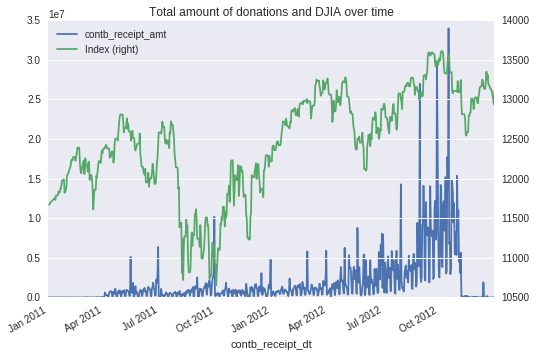

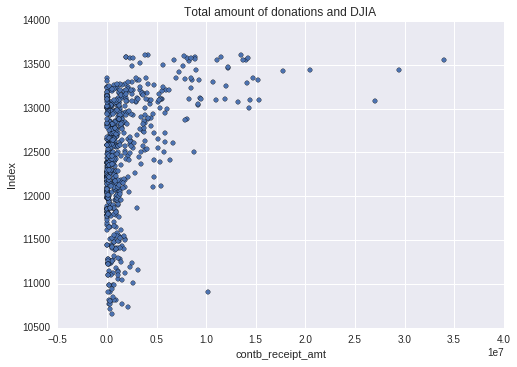

In [44]:
total_donations_per_day_djia = pandas.merge(left = donations.groupby('contb_receipt_dt').sum(), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and total donations amount: '
      + str(total_donations_per_day_djia['contb_receipt_amt'].corr(total_donations_per_day_djia['Index'])))

total_donations_per_day_djia.plot(title = 'Total amount of donations and DJIA over time', secondary_y='Index')
total_donations_per_day_djia.plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA')

As we can see there is a weak correlation between the DJIA index and the total amount of donations.

Correlation between index and cumulative total donations amount: 0.613520151756


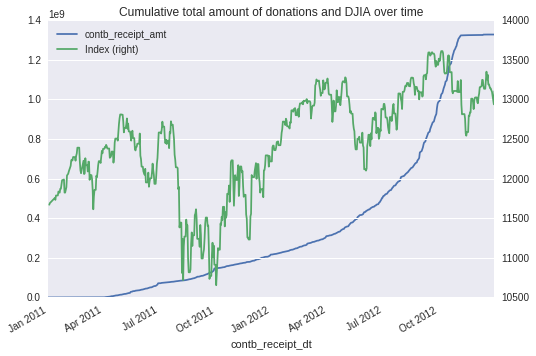

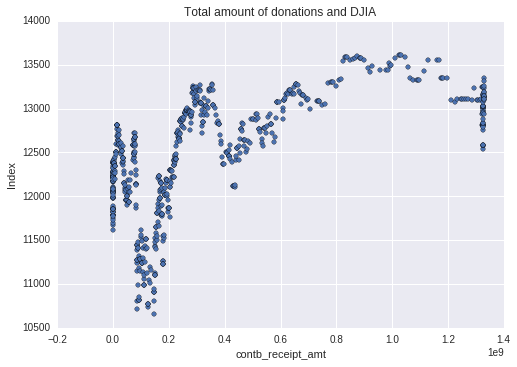

In [45]:
cumulative_total_donations_per_day_djia = pandas.merge(left = donations.groupby('contb_receipt_dt').sum(), right = djia,
                                            left_index = True, right_index = True, how = 'left')
cumulative_total_donations_per_day_djia.contb_receipt_amt = cumulative_total_donations_per_day_djia.contb_receipt_amt.cumsum()

print('Correlation between index and cumulative total donations amount: '
      + str(cumulative_total_donations_per_day_djia['contb_receipt_amt'].corr(cumulative_total_donations_per_day_djia['Index'])))

cumulative_total_donations_per_day_djia.plot(title = 'Cumulative total amount of donations and DJIA over time', secondary_y='Index')
cumulative_total_donations_per_day_djia.plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA')

There is a stronger correlation between the cumulative total amount of donations and the DJIA index, but this doesn't provide much information; the stock market index rises in general (if there is no financial crisis indeed) as do the money one gathers during a campaign.

Correlation between index and number of donations: 0.423499410848


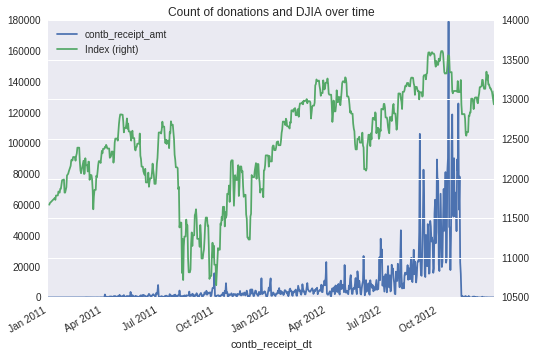

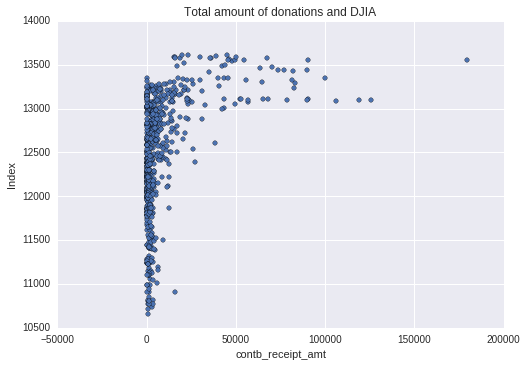

In [47]:
count_donations_per_day_djia = pandas.merge(left = donations.groupby('contb_receipt_dt').count(), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and number of donations: '
      + str(count_donations_per_day_djia['contb_receipt_amt'].corr(count_donations_per_day_djia['Index'])))

count_donations_per_day_djia[['contb_receipt_amt', 'Index']].plot(title = 'Count of donations and DJIA over time', secondary_y='Index')
count_donations_per_day_djia[['contb_receipt_amt', 'Index']].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA')

There is a medium-weak correlation between the number of donations and the DJIA. Again this is not much information as there is another reason the number of donation rises as we will see bellow.

Correlation between index and mean donation amount: -0.277407953413


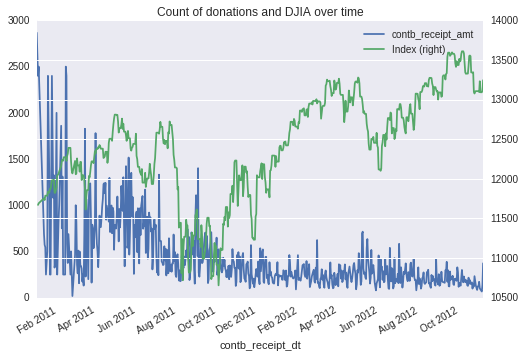

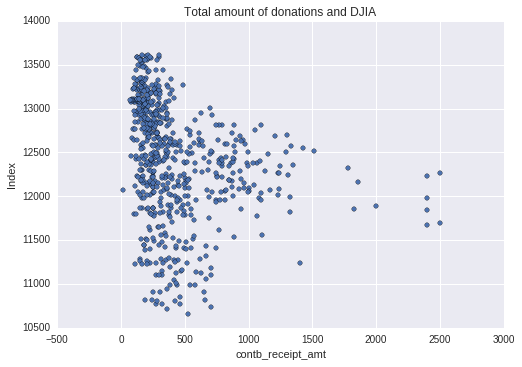

In [48]:
mean_donations_per_day_djia = pandas.merge(left = donations[donations.contb_receipt_dt <= '2012-11-6'].groupby('contb_receipt_dt').mean(), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and mean donation amount: '
      + str(mean_donations_per_day_djia['contb_receipt_amt'].corr(mean_donations_per_day_djia['Index'])))

mean_donations_per_day_djia.plot(title = 'Count of donations and DJIA over time', secondary_y='Index')
mean_donations_per_day_djia.plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA')

Correlation between index and median donations amount: -0.190206583769


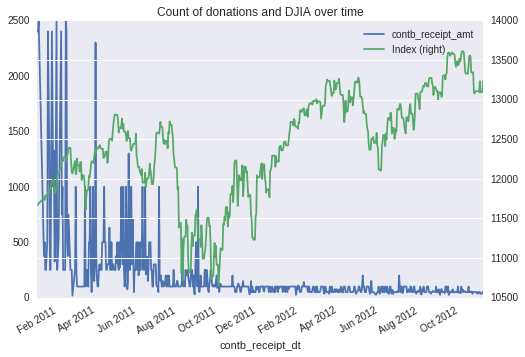

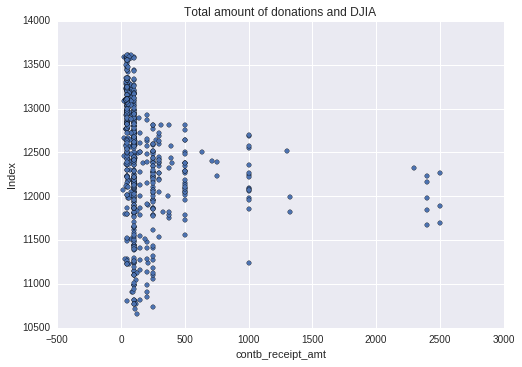

In [49]:
mean_donations_per_day_djia = pandas.merge(left = donations[donations.contb_receipt_dt <= '2012-11-6'].groupby('contb_receipt_dt').median(), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and median donations amount: '
      + str(mean_donations_per_day_djia['contb_receipt_amt'].corr(mean_donations_per_day_djia['Index'])))

mean_donations_per_day_djia.plot(title = 'Count of donations and DJIA over time', secondary_y='Index')
mean_donations_per_day_djia.plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA')

Finally the mean and median doantion seem to be unrelated to the index of DJIA.

The supporters of different parties may react differently to the DJIA index so we are going to separate the donations by party.

In [50]:
donations.cand_nm.unique()

array(['Bachmann, Michele', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick', 'Stein, Jill'], dtype=object)

Looking the names online (or in the presentation of lecture 5) we determine which party each candidate belongs to and add a party column to the donations data frame.

In [51]:
parties = {
    'Bachmann, Michele': 'Republican',
    'Romney, Mitt': 'Republican',
    'Obama, Barack': 'Democrat',
    "Roemer, Charles E. 'Buddy' III": 'Republican',
    'Pawlenty, Timothy': 'Republican',
    'Johnson, Gary Earl': 'Republican',
    'Paul, Ron': 'Republican', 
    'Santorum, Rick': 'Republican',
    'Cain, Herman': 'Republican',
    'Gingrich, Newt': 'Republican', 
    'McCotter, Thaddeus G': 'Republican',
    'Huntsman, Jon': 'Republican',
    'Perry, Rick': 'Republican',
    'Stein, Jill': 'Republican'
}

donations['party'] = donations.cand_nm.map(parties)

We will group our data by party and date and calculate the correlations again.

Correlation between index and total donations amount to Republicans: 0.368962149778
Correlation between index and total donations amount to Democrats: 0.324503257218


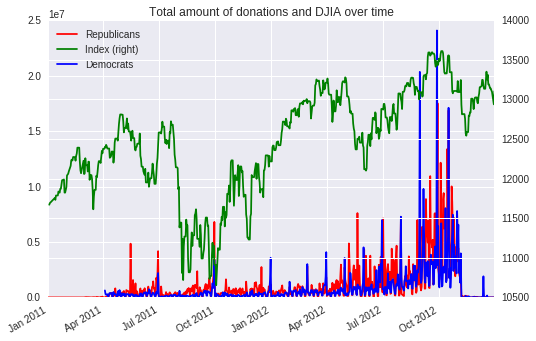

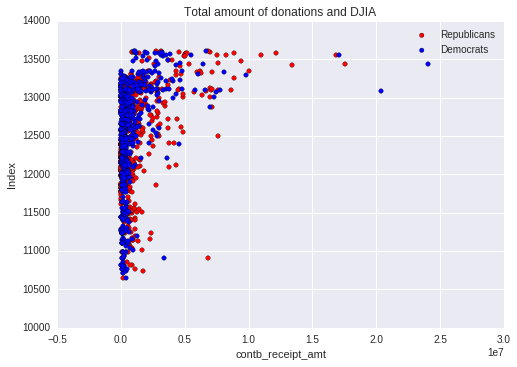

In [106]:
total_donations_per_day_per_party_djia = pandas.merge(left = donations.groupby(['contb_receipt_dt', 'party']).sum().reset_index(level=1), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and total donations amount to Republicans: '
      + str(total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Republican']['contb_receipt_amt'].corr(total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Republican']['Index'])))
print('Correlation between index and total donations amount to Democrats: '
      + str(total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Democrat']['contb_receipt_amt'].corr(total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Democrat']['Index'])))

ax = total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Republican'].plot(title = 'Total amount of donations and DJIA over time', y = 'contb_receipt_amt', color='Red', label='Republicans')
total_donations_per_day_per_party_djia.plot(y = 'Index', secondary_y=True, color='Green', label='Index', ax=ax)
total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Democrat'].plot(y='contb_receipt_amt', title = 'Total amount of donations and DJIA over time', color='Blue', label='Democrats', ax=ax)

ax = total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Republican'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Total amount of donations and DJIA', color = 'Red', label = 'Republicans')
total_donations_per_day_per_party_djia[total_donations_per_day_per_party_djia.party == 'Democrat'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', color = 'Blue', label = 'Democrats', ax=ax)

The correlation between DJIA index and total amount of donations is weak for both parties.

Correlation between index and count of donations amount to Republicans: 0.406914404888
Correlation between index and count of donations amount to Democrats: 0.39956708404


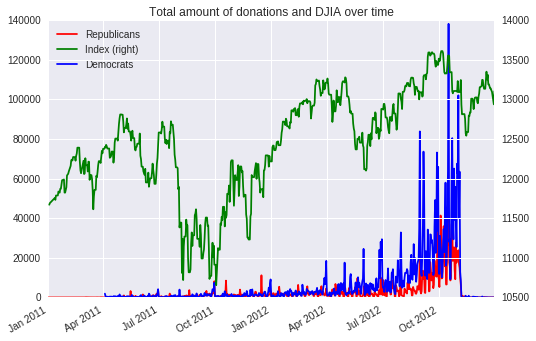

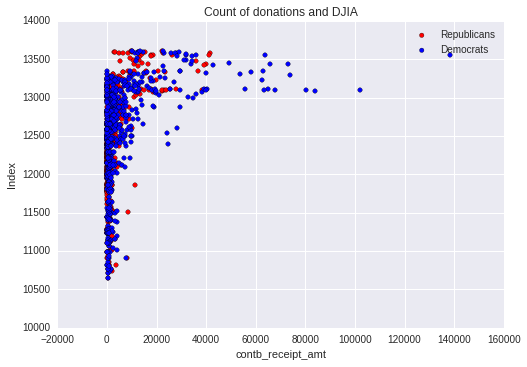

In [110]:
count_donations_per_day_per_party_djia = pandas.merge(left = donations.groupby(['contb_receipt_dt', 'party']).count().reset_index(level=1), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and count of donations amount to Republicans: '
      + str(count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Republican']['contb_receipt_amt'].corr(count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Republican']['Index'])))
print('Correlation between index and count of donations amount to Democrats: '
      + str(count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Democrat']['contb_receipt_amt'].corr(count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Democrat']['Index'])))

ax = count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Republican'].plot(title = 'Count of donations and DJIA over time', y = 'contb_receipt_amt', color='Red', label='Republicans')
count_donations_per_day_per_party_djia.plot(y = 'Index', secondary_y=True, color='Green', label='Index', ax=ax)
count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Democrat'].plot(y='contb_receipt_amt', title = 'Total amount of donations and DJIA over time', color='Blue', label='Democrats', ax=ax)

ax = count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Republican'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Count of donations and DJIA', color = 'Red', label = 'Republicans')
count_donations_per_day_per_party_djia[count_donations_per_day_per_party_djia.party == 'Democrat'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', color = 'Blue', label = 'Democrats', ax=ax)

Again the correlation between the number of donations and the DJIA index is weak.

Correlation between index and mean donation amount to Republicans: -0.201301626692
Correlation between index and mean donation amount to Democrats: -0.259288100994


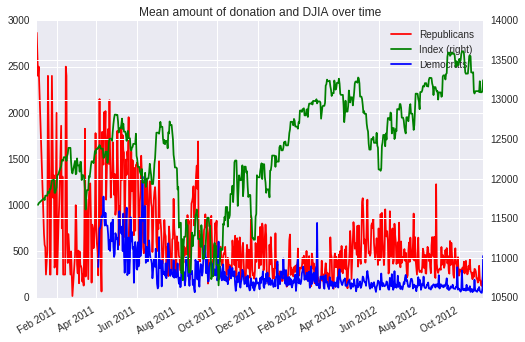

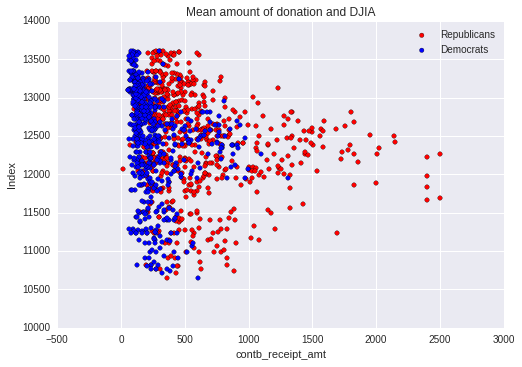

In [112]:
# We remove donations after the elections because there are very few and a rather large one destroys the graph
mean_donations_per_day_per_party_djia = pandas.merge(left = donations[donations.contb_receipt_dt <= '2012-11-06'].groupby(['contb_receipt_dt', 'party']).mean().reset_index(level=1), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and mean donation amount to Republicans: '
      + str(mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Republican']['contb_receipt_amt'].corr(mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Republican']['Index'])))
print('Correlation between index and mean donation amount to Democrats: '
      + str(mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Democrat']['contb_receipt_amt'].corr(mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Democrat']['Index'])))

ax = mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Republican'].plot(title = 'Mean amount of donation and DJIA over time', y = 'contb_receipt_amt', color='Red', label='Republicans')
mean_donations_per_day_per_party_djia.plot(y = 'Index', secondary_y=True, color='Green', label='Index', ax=ax)
mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Democrat'].plot(y='contb_receipt_amt', title = 'Mean amount of donation and DJIA over time', color='Blue', label='Democrats', ax=ax)

ax = mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Republican'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Mean amount of donation and DJIA', color = 'Red', label = 'Republicans')
mean_donations_per_day_per_party_djia[mean_donations_per_day_per_party_djia.party == 'Democrat'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', color = 'Blue', label = 'Democrats', ax=ax)

Correlation between index and median donation amount to Republicans: -0.127779231205
Correlation between index and median donation amount to Democrats: -0.125892826653


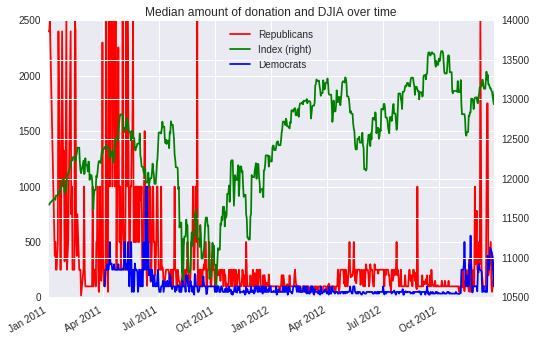

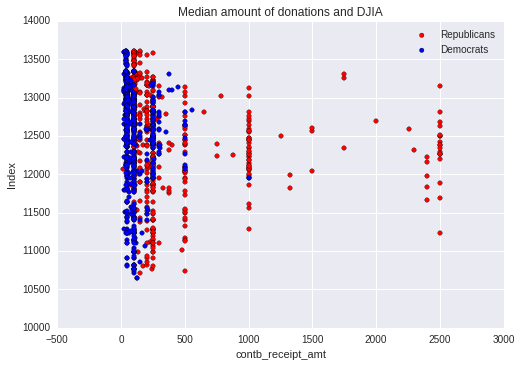

In [118]:
median_donations_per_day_per_party_djia = pandas.merge(left = donations.groupby(['contb_receipt_dt', 'party']).median().reset_index(level=1), right = djia,
                                            left_index = True, right_index = True, how = 'left')
print('Correlation between index and median donation amount to Republicans: '
      + str(median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Republican']['contb_receipt_amt'].corr(median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Republican']['Index'])))
print('Correlation between index and median donation amount to Democrats: '
      + str(median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Democrat']['contb_receipt_amt'].corr(median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Democrat']['Index'])))

ax = median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Republican'].plot(title = 'Median amount of donation and DJIA over time', y = 'contb_receipt_amt', color='Red', label='Republicans')
median_donations_per_day_per_party_djia.plot(y = 'Index', secondary_y=True, color='Green', label='Index', ax=ax)
median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Democrat'].plot(y='contb_receipt_amt', title = 'Median amount of donation and DJIA over time', color='Blue', label='Democrats', ax=ax)

ax = median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Republican'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', title = 'Median amount of donations and DJIA', color = 'Red', label = 'Republicans')
median_donations_per_day_per_party_djia[median_donations_per_day_per_party_djia.party == 'Democrat'].plot(kind = 'scatter', x = 'contb_receipt_amt', y='Index', color = 'Blue', label = 'Democrats', ax=ax)

Again the mean and median amount of doantions are not related to the DJIA index

### Days left till election

The election day was November the 6th of 2012. It would be interesting to see the amount of donations as the election day approaches.

Correlation between days until election and total donation amount-0.559092533748


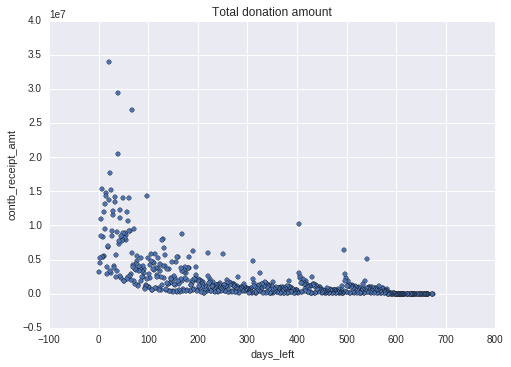

In [140]:
donations_per_day_days_left = donations[donations.contb_receipt_dt <= '2012-11-06'].groupby('contb_receipt_dt', as_index=False).sum()
donations_per_day_days_left['days_left'] = (pandas.to_datetime('2012-11-06') - donations_per_day_days_left.contb_receipt_dt).dt.days
donations_per_day_days_left[(donations_per_day_days_left.days_left > 0)].plot(kind='scatter', x= 'days_left', y='contb_receipt_amt', title = 'Total donation amount')
print('Correlation between days until election and total donation amount' + str(donations_per_day_days_left['contb_receipt_amt'][donations_per_day_days_left.days_left > 0].corr(donations_per_day_days_left['days_left'])))

We have removed the entries after the election day as there is naturally a drop to the amount of donation after the elections. We can see that there is a medium strength correlation between the amount of days left until election and the total amount of donation to the campaigns.

## Census data

We have retrieved the census 2010 data from www.census.gov. There one main file we are interested in. The geography file which lists all census statictical locations and the total population for each statistical location. The geography file is fixed width and can be retrieved from [here](ftp://ftp.census.gov/census_2010/04-Summary_File_1/National/us2010.sf1.zip). The dictionary and other documentation for this data set is [here](http://www.census.gov/prod/cen2010/doc/sf1.pdf)

In [141]:
if not os.path.isfile('sf1/usgeo2010.sf1'):
    if not os.path.isfile('sf1/us2010.sf1.zip'):
        urllib.request.urlretrieve('ftp://ftp.census.gov/census_2010/04-Summary_File_1/National/us2010.sf1.zip',
                                   filename = 'sf1/us2010.sf1.zip')
    zipped_data_set = zipfile.ZipFile('sf1/us2010.sf1.zip')
    zipped_data_set.extract(member = 'usgeo2010.sf1', path = 'sf1/')

usgeo2010_widths = [6, 2, 3, 2, 3, 2, 7, 1, 1, 2, 3, 2, 2, 5, 2, 2, 5, 2, 2, 6, 1, 4, 2, 5, 2, 2, 4, 5, 2, 1, 3, 5, 2, 6, 1, 5, 2, 5, 2, 5, 3, 5, 2, 5, 3, 1, 1, 5, 2, 1, 1, 2, 3, 3, 6, 1, 3, 5, 5, 2, 5, 5, 5, 14, 14, 90, 1, 1, 9, 9, 11, 12, 2, 1, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 5, 18]
usgeo2010_names = ['FILEID', 'STUSAB', 'SUMLEV', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO',
         'REGION', 'DIVISION', 'STATE', 'COUNTY', 'COUNTYCC', 'COUNTYSC', 'COUSUB',
         'COUSUBCC', 'COUSUBSC', 'PLACE', 'PLACECC', 'PLACESC', 'TRACT', 'BLKGRP',
         'BLOCK', 'IUC', 'CONCIT', 'CONCITCC', 'CONCITSC', 'AIANHH', 'AIANHHFP',
         'AIANHHCC', 'AIHHTLI', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'TBLKGRP',
         'ANRC', 'ANRCCC', 'CBSA', 'CBSASC', 'METDIV', 'CSA', 'NECTA',
         'NECTASC', 'NECTADIV', 'CNECTA', 'CBSAPCI', 'NECTAPCI', 'UA', 'UASC',
         'UATYPE', 'UR', 'CD', 'SLDU', 'SLDL', 'VTD', 'VTDI',
         'RESERVE2', 'ZCTA5', 'SUBMCD', 'SUBMCDCC', 'SDELM', 'SDSEC', 'SDUNI',
         'AREALAND', 'AREAWATR', 'NAME', 'FUNCSTAT', 'GCUNI', 'POP100', 'HU100',
         'INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'RESERVE3', 'UGA', 'STATENS',
         'COUNTYNS', 'COUSUBNS', 'PLACENS', 'CONCITNS', 'AIANHHNS', 'AITSNS', 'ANRCNS',
         'SUBMCDNS', 'CD113', 'CD114', 'CD115', 'SLDU2', 'SLDU3', 'SLDU4',
         'SLDL2', 'SLDL3', 'SLDL4', 'AIANHHSC', 'CSASC', 'CNECTASC', 'MEMI',
         'NMEMI', 'PUMA', 'RESERVED']
usgeo2010_states = {1:'AL',
                    2:'AK',
                    4:'AZ',
                    5:'AR',
                    6:'CA',
                    8:'CO',
                    9:'CT',
                    10:'DE',
                    11:'DC',
                    12:'FL',
                    13:'GA',
                    15:'HI',
                    16:'ID',
                    17:'IL',
                    18:'IN',
                    19:'IA',
                    20:'KS',
                    21:'KY',
                    22:'LA',
                    23:'ME',
                    24:'MD',
                    25:'MA',
                    26:'MI',
                    27:'MN',
                    28:'MS',
                    29:'MO',
                    30:'MT',
                    31:'NE',
                    32:'NV',
                    33:'NH',
                    34:'NJ',
                    35:'NM',
                    36:'NY',
                    37:'NC',
                    38:'ND',
                    39:'OH',
                    40:'OK',
                    41:'OR',
                    42:'PA',
                    44:'RI',
                    45:'SC',
                    46:'SD',
                    47:'TN',
                    48:'TX',
                    49:'UT',
                    50:'VT',
                    51:'VA',
                    53:'WA',
                    54:'WV',
                    55:'WI',
                    56:'WY',
                    72:'Puerto_Rico'}

usgeo2010 = pandas.read_fwf('sf1/usgeo2010.sf1', widths = usgeo2010_widths, header = None, names = usgeo2010_names)
usgeo2010['STATE'] = usgeo2010.STATE.map(usgeo2010_states)

We will try to clean the donations data set. We observer that there are someentries which contain state acronums that do not exist. This is due to donation from aboard or mistaken entries.

In [142]:
donations.contbr_st[~donations.contbr_st.isin(usgeo2010_states.values())].unique()
print('There are ' + str(len(donations.contbr_st[~donations.contbr_st.isin(usgeo2010_states.values())])) + ' entries with invalid states')

There are 13237 entries with invalid states


We will remove these.

In [143]:
donations = donations[donations.contbr_st.isin(usgeo2010_states.values())]

Also there are 84 entries where there is no city reported. We will remove those two as we don't want to match a whole state.

In [144]:
print('There are ' + str(len(donations[donations.contbr_city.isnull()])) + ' entries with no city recorded')
donations = donations[~donations.contbr_city.isnull()]

There are 82 entries with no city recorded


In [180]:
donations_by_state_city = donations.groupby(['contbr_st', 'contbr_city', 'party'], as_index = False).sum()
donations_by_state_city.contbr_city = donations_by_state_city.contbr_city.str.translate(str.maketrans(string.punctuation,' '*len(string.punctuation))).str.strip()
donations_by_state_city.head()

,contbr_st,contbr_city,party,contb_receipt_amt
0,AK,AKIAK,Democrat,764
1,AK,AKUTAN,Republican,210
2,AK,ALAKANUK,Republican,250
3,AK,AMBLER,Democrat,2185
4,AK,ANC,Democrat,225


As we can see the city names can have several typos, same cities are written with different spellings and the names will differ from the ones used by the census organization. To overcome these problems we will use fuzzy matching with the difflib library (using Levenshtein distance). We will try to match the reported city name with a 'place' (sumlevel 70) within the same state in the census data. If several places with similar names exist (eg Ankhorage, Ankhorage subarbs etc) we will pick the one with the largest population. This may take some time and memory.

In [182]:
def fuzzy_match(x):
    a = difflib.get_close_matches(x[1], usgeo2010.NAME[(usgeo2010.STATE == x[0]) & ((usgeo2010.SUMLEV == 70) | (usgeo2010.SUMLEV == 70))].str.upper().unique(), n=1, cutoff = 0.5)
    if len(a)>0:
        return a[0]
    else:
        return None

donations_by_state_city['fuzzy_name'] = donations_by_state_city.apply(fuzzy_match, axis=1)

,contbr_st,contbr_city,party,contb_receipt_amt,fuzzy_name
0,AK,AKIAK,Democrat,764.00,AKIAK CITY
1,AK,AKUTAN,Republican,210.00,AKUTAN CITY
2,AK,ALAKANUK,Republican,250.00,ALAKANUK CITY
3,AK,AMBLER,Democrat,2185.00,AMBLER CITY
4,AK,ANC,Democrat,225.00,SLANA CDP
5,AK,ANCHOR POINT,Democrat,85.00,ANCHOR POINT CDP
6,AK,ANCHOR POINT,Republican,5002.00,ANCHOR POINT CDP
7,AK,ANCHORAGE,Democrat,729587.64,ANCHORAGE MUNICIPALITY
8,AK,ANCHORAGE,Republican,805378.24,ANCHORAGE MUNICIPALITY
9,AK,ANCHORAGE,Democrat,75.00,ANCHORAGE MUNICIPALITY


In [187]:
print('Number of cities not recognized: '
      + str(len(donations_by_state_city[donations_by_state_city.fuzzy_name.isnull()].contbr_city.unique()))
      + '. The amount these cities contributed is: $'
      + str(donations_by_state_city[donations_by_state_city.fuzzy_name.isnull()].contb_receipt_amt.sum()))

Number of cities not recognized: 1957. The amount these cities contributed is: $24775155.8


Many of the unrecognized cities are due to errors. E.g. Wrong combination of State and City name. For this reason we will remove these entries.

In [190]:
donations_by_state_city = donations_by_state_city[~donations_by_state_city.fuzzy_name.isnull()]

Again we will groupby state and city name and sum to sum the corrected city names

In [191]:
donations_by_state_city = donations_by_state_city.groupby(['contbr_st', 'fuzzy_name', 'party'], as_index = False).sum()

,contbr_st,fuzzy_name,party,contb_receipt_amt
0,AK,AKIAK CITY,Democrat,764.00
1,AK,AKUTAN CITY,Republican,210.00
2,AK,ALAKANUK CITY,Republican,250.00
3,AK,ALATNA CDP,Democrat,2700.00
4,AK,ALATNA CDP,Republican,250.00
5,AK,AMBLER CITY,Democrat,2185.00
6,AK,ANCHOR POINT CDP,Democrat,85.00
7,AK,ANCHOR POINT CDP,Republican,5002.00
8,AK,ANCHORAGE MUNICIPALITY,Democrat,730145.64
9,AK,ANCHORAGE MUNICIPALITY,Republican,810378.24


Now we will merge the donations data with the census data

In [192]:
usgeo2010['NAME_UPPER'] = usgeo2010['NAME'].str.upper()
donations_by_state_city=pandas.merge(left=donations_by_state_city, right=usgeo2010[['POP100', 'NAME_UPPER', 'STATE']][(usgeo2010.SUMLEV == 70)].sort_values('POP100', ascending=False).drop_duplicates(subset = ['NAME_UPPER', 'STATE'], keep = 'first'), left_on = ['contbr_st','fuzzy_name'], right_on = ['STATE','NAME_UPPER'], how = 'left')

We will separate the cities in bins based on their size. We will use the same bins as the census organization:

In [193]:
def bins(x):
    if x[0] < 25000:
        return '0-25000'
    elif x[0] < 50000:
        return '25000-50000'
    elif x[0] < 100000:
        return '50000-100000'
    elif x[0] < 250000:
        return '100000-250000'
    elif x[0] < 500000:
        return '250000-500000'
    elif x[0] < 1000000:
        return '500000-1000000'
    elif x[0] < 2500000:
        return '1000000-2500000'
    else:
        return '2500000+'

donations_by_state_city['city_size'] = donations_by_state_city[['POP100']].apply(bins, axis=1)

,contbr_st,fuzzy_name,party,contb_receipt_amt,POP100,NAME_UPPER,STATE,city_size
0,AK,AKIAK CITY,Democrat,764.00,346,AKIAK CITY,AK,0-25000
1,AK,AKUTAN CITY,Republican,210.00,1027,AKUTAN CITY,AK,0-25000
2,AK,ALAKANUK CITY,Republican,250.00,677,ALAKANUK CITY,AK,0-25000
3,AK,ALATNA CDP,Democrat,2700.00,37,ALATNA CDP,AK,0-25000
4,AK,ALATNA CDP,Republican,250.00,37,ALATNA CDP,AK,0-25000
5,AK,AMBLER CITY,Democrat,2185.00,258,AMBLER CITY,AK,0-25000
6,AK,ANCHOR POINT CDP,Democrat,85.00,1930,ANCHOR POINT CDP,AK,0-25000
7,AK,ANCHOR POINT CDP,Republican,5002.00,1930,ANCHOR POINT CDP,AK,0-25000
8,AK,ANCHORAGE MUNICIPALITY,Democrat,730145.64,291826,ANCHORAGE MUNICIPALITY,AK,250000-500000
9,AK,ANCHORAGE MUNICIPALITY,Republican,810378.24,291826,ANCHORAGE MUNICIPALITY,AK,250000-500000


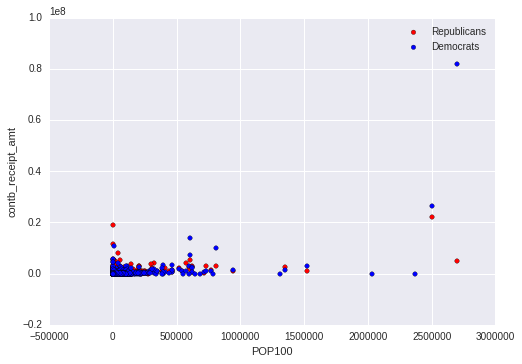

In [195]:
ax = donations_by_state_city[(donations_by_state_city.party == 'Republican')].plot(kind='scatter', x='POP100', y='contb_receipt_amt', color='Red', label = 'Republicans')
donations_by_state_city[(donations_by_state_city.party == 'Democrat')].plot(kind='scatter', x='POP100', y='contb_receipt_amt', color='Blue', label = 'Democrats', ax=ax)

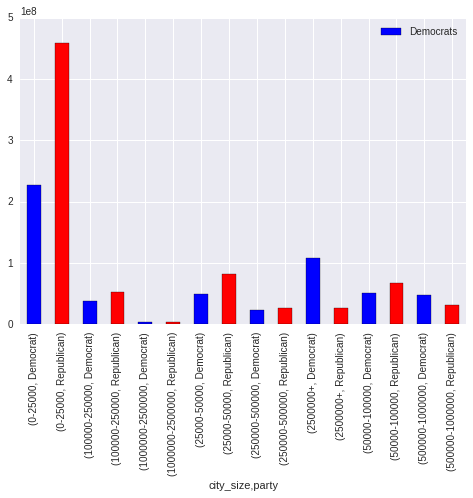

In [206]:
ax = donations_by_state_city.groupby(['city_size', 'party']).sum().drop('POP100', axis=1).plot(kind = 'bar', y='contb_receipt_amt', color = ['Blue', 'Red'], label = 'Democrats')

As we can see in the barplot above the Democrats gathered much more donations in large and medium sized cities while the Republicans gathered many more donations in small towns.